In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import thinkstats2
from statsmodels.stats.power import TTestPower

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

# Covid Death Rates in Murica

Use this data to attempt the analysis below. The section headers below are how I organized it, not a strict requirement. 

In [3]:
df = pd.read_csv("data/covid_deaths.csv")
df.head()

,Day,unvaccinated,fully_vaccinated,one_booster,two_boosters
0,2022-04-02,2.405073,0.384576,0.269884,0.290136
1,2022-04-09,2.342870,0.366587,0.324628,0.695672
2,2022-04-16,2.349217,0.451211,0.346906,0.230545
3,2022-04-23,2.454704,0.516000,0.546689,0.062556
4,2022-04-30,3.308662,0.637330,0.681762,0.259442


<AxesSubplot:xlabel='Day', ylabel='unvaccinated'>

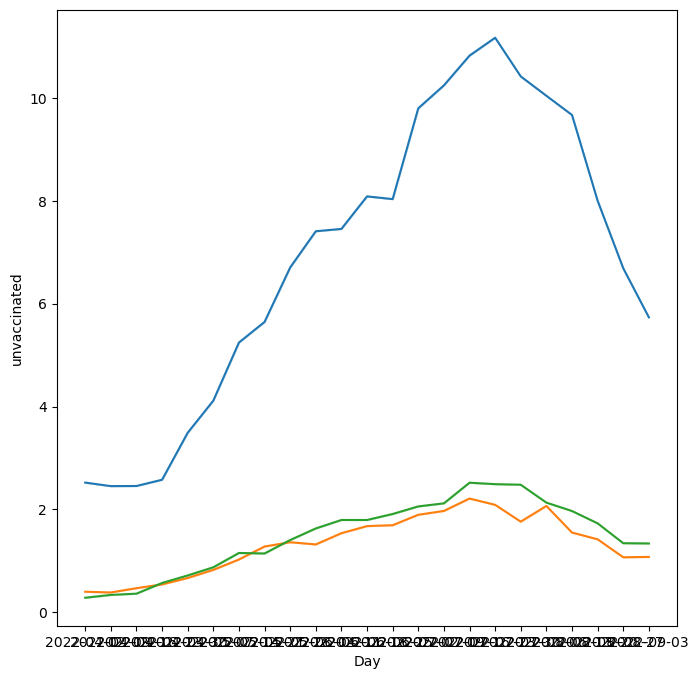

In [4]:
sns.lineplot(data=df, x="Day", y="unvaccinated", ci=0)
sns.lineplot(data=df, x="Day", y="fully_vaccinated", ci=0)
sns.lineplot(data=df, x="Day", y="one_booster", ci=0)

## Is there a significant difference in death rates between Fully Vaccinated people and Unvaccinated people?

#### Create Datasets

In [12]:
fv=df["fully_vaccinated"]
uv=df["unvaccinated"]

#### Explore Datasets

<AxesSubplot:xlabel='fully_vaccinated', ylabel='Density'>

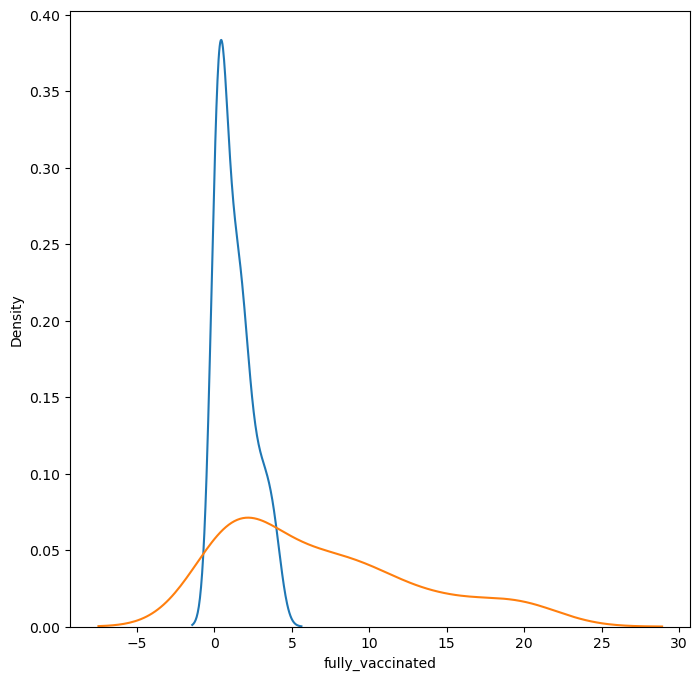

In [13]:
sns.kdeplot(fv)
sns.kdeplot(uv)

### Hypothesis Test

First I'll try a regular t-test, then I'll do the non-parametric version, the Mann-Whitney. 

In [14]:
# t-test
ss.ttest_ind(fv,uv)


Ttest_indResult(statistic=-7.454552636718715, pvalue=9.50701441183468e-12)

In [15]:
# mw
ss.mannwhitneyu(fv,uv)


MannwhitneyuResult(statistic=845.0, pvalue=6.299258240567537e-11)

### Calculate Power

In [16]:
# Calculate inputs
fmean,fmedian,fstd,fcount= np.mean(fv),np.median(fv), np.std(fv), fv.count()
umean, umedian, ustd, ucount= np.mean(uv),np.median(uv),np.std(uv), uv.count()


In [18]:
# calculate power
from statsmodels.stats.power import TTestPower
powerTest = TTestPower()

ces = thinkstats2.CohenEffectSize(uv, fv)
alpha = .05
nobs = fcount + ucount

pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow, ces

(1.0, 1.2691473231783308)

### Result

Looks like a statistically significant difference, by every metric. 

## Is There a Significant Difference in Death Rates Between Fully Vaccinated and Boosted Populations*

*The boosted population has two groups - those with one booster and those with two. The one booster group is larger than the two booster group - there are more people with only one booster than there are with two. Use the below ratio to generate a weighted average rate. I.e. if the ratio is .2, that means that 20% of the total boosted population has two doses and 80% have one dose. 

You'll have to calculate this weighted death rate, it should (probably - there's lots of potential ways you could do it) be a simple calculation that spits the result into a new column. 

In [19]:
two_dose_ratio = .2

In [20]:
b1 = df["one_booster"]
b2 = df["two_boosters"]
boost = (b1 * (1 - two_dose_ratio)) + (b2 * two_dose_ratio)
boost

0     0.273934
1     0.398837
2     0.323634
3     0.449862
4     0.597298
        ...   
64    3.566121
65    3.163846
66    2.930213
67    2.260076
68    2.290633
Length: 69, dtype: float64

#### Explore

<AxesSubplot:xlabel='fully_vaccinated', ylabel='Density'>

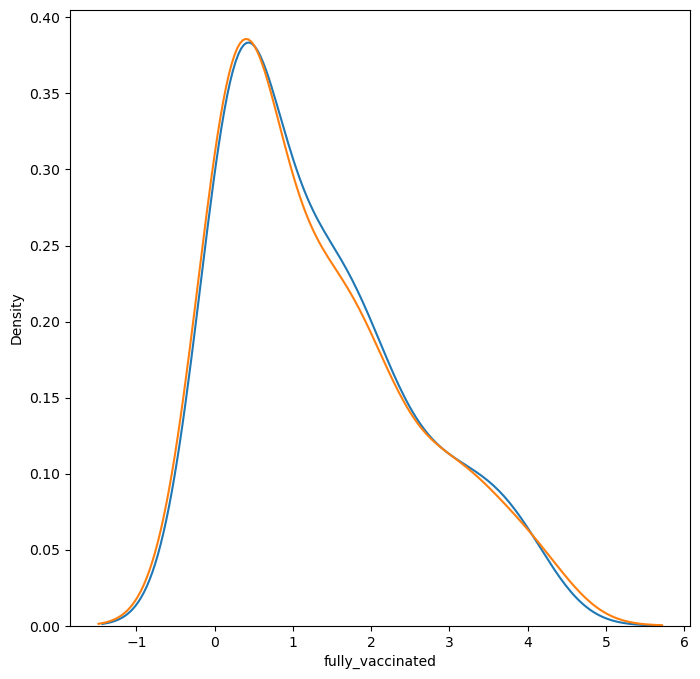

In [21]:
sns.kdeplot(fv)
sns.kdeplot(boost)

#### Test

In [22]:
# t-test
print(ss.ttest_ind(fv, boost))
# mw
print(ss.mannwhitneyu(fv,boost))

Ttest_indResult(statistic=0.08839172910537565, pvalue=0.929695361047642)
MannwhitneyuResult(statistic=2440.0, pvalue=0.8016297416888358)


#### Power

In [31]:
# Calculate inputs
bcount=boost.count()
# calculate power
ces1 = thinkstats2.CohenEffectSize(fv, boost)
alpha = .05
nobs1 = fcount + bcount

pow1 = powerTest.power(effect_size=ces1, nobs=nobs1, alpha=alpha)
pow1, ces1

(0.05353763977604623, 0.01504880733320184)

#### How Large of a Sample is Needed for a Power of .8?

In [32]:
size_smpl= powerTest.solve_power(effect_size=ces1, alpha=alpha,power=.8)
size_smpl

34659.83744287985

#### More Sophisticated Rates

We can improve the approximation of the number of people with two boosters vs one booster. For this part, try to consider the following, and put this into your data:
<ul>
<li> There is a starting rate of two booster people (similar to above - the proportion of boosted people with 2 boosters). Try this being <b>.1</b>
<li> There is a final rate of two booster people. Try with this being <b>.3</b>
<li> Each day, the ratio of people with boosters who have two increases a set amount, starting with the first value (.1) on day 1, and the last (.3) on the last day. 
</ul>

<b>Note:</b> This is more of a challenge of manipulating the data than of the hypothesis testing. Once the datasets are established, the process is the same as above. The function "np.arange" may be useful here, but there's probably lots of ways to do it. 

In [39]:
# Plot Ratios
start = .1
cap = .3
inc=(cap-start)/len(df)

df["ratio"]=np.arange(start, cap, inc)
df.head(10)


,Day,unvaccinated,fully_vaccinated,one_booster,two_boosters,avgBoost,ratio
0,2022-04-02,2.405073,0.384576,0.269884,0.290136,0.100000,0.100000
1,2022-04-09,2.342870,0.366587,0.324628,0.695672,0.102899,0.102899
2,2022-04-16,2.349217,0.451211,0.346906,0.230545,0.105797,0.105797
3,2022-04-23,2.454704,0.516000,0.546689,0.062556,0.108696,0.108696
4,2022-04-30,3.308662,0.637330,0.681762,0.259442,0.111594,0.111594
5,2022-05-07,3.906787,0.786702,0.829998,0.183629,0.114493,0.114493
6,2022-05-14,4.980379,0.978166,1.099473,0.298671,0.117391,0.117391
7,2022-05-21,5.367513,1.218164,1.087876,0.257800,0.120290,0.120290
8,2022-05-28,6.370582,1.298730,1.334231,0.402034,0.123188,0.123188
9,2022-06-04,7.035629,1.251821,1.553023,0.640155,0.126087,0.126087


In [ ]:
# Add ratio to df


In [40]:
# Generate Weighted Boosted Rate
df["avgBoost"]=(df["one_booster"]*(1-df["ratio"]))+(df["two_boosters"]*df["ratio"])
df.head(10)

,Day,unvaccinated,fully_vaccinated,one_booster,two_boosters,avgBoost,ratio
0,2022-04-02,2.405073,0.384576,0.269884,0.290136,0.271909,0.100000
1,2022-04-09,2.342870,0.366587,0.324628,0.695672,0.362808,0.102899
2,2022-04-16,2.349217,0.451211,0.346906,0.230545,0.334596,0.105797
3,2022-04-23,2.454704,0.516000,0.546689,0.062556,0.494066,0.108696
4,2022-04-30,3.308662,0.637330,0.681762,0.259442,0.634634,0.111594
5,2022-05-07,3.906787,0.786702,0.829998,0.183629,0.755993,0.114493
6,2022-05-14,4.980379,0.978166,1.099473,0.298671,1.005466,0.117391
7,2022-05-21,5.367513,1.218164,1.087876,0.257800,0.988026,0.120290
8,2022-05-28,6.370582,1.298730,1.334231,0.402034,1.219395,0.123188
9,2022-06-04,7.035629,1.251821,1.553023,0.640155,1.437922,0.126087


### Do Test

In [42]:
wboost=df["avgBoost"]

In [43]:
# t-test
print(ss.ttest_ind(fv,wboost))
# mw
print(ss.mannwhitneyu(fv,wboost))

Ttest_indResult(statistic=0.22626533389464973, pvalue=0.8213347682947116)
MannwhitneyuResult(statistic=2445.0, pvalue=0.7852146286001633)


#### Power

In [44]:
# Calculate inputs
wcount=wboost.count()
# calculate power
cesw=thinkstats2.CohenEffectSize(fv,wboost)
nobsw=fcount+wcount

posw=powerTest.power(effect_size=cesw, nobs=nobsw, alpha=.05)
posw,cesw

(0.07343642074566771, 0.03852196863242589)

## ANOVA

Is there a significant difference between any of the 3 vaccinated groups? Can you test it? 

In [49]:
df["fully_vaccinated"].var(), df["one_booster"].var(), df["two_boosters"].var()

(1.3195206562272244, 1.8526001242998276, 0.23117763061071334)

In [46]:
#First, test for vars being equal-ish
ss.levene(df["fully_vaccinated"],df["one_booster"],df["two_boosters"])

LeveneResult(statistic=21.83232868299384, pvalue=2.559442889524628e-09)

In [47]:
ss.f_oneway(df["fully_vaccinated"],df["one_booster"],df["two_boosters"])

F_onewayResult(statistic=14.837969257926622, pvalue=9.630515251959147e-07)

In [51]:
print(ss.f_oneway(df["fully_vaccinated"],df["one_booster"]))
print(ss.levene(df["fully_vaccinated"],df["one_booster"]))

F_onewayResult(statistic=0.6130507740996793, pvalue=0.43500274213048107)
LeveneResult(statistic=1.7396878475982294, pvalue=0.18939493377087885)
